# Vending Machine simulator

an effort to make a Monte-Carlo simulator for VM that will help to understand effect of different policies about product selection and refil strategy.

In [1]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
from matplotlib import pyplot as plt

from vmSim import *

# %matplotlib inline
%matplotlib widget
%load_ext autoreload
%autoreload 2


## Future considerations
- [ ] ML to find best strategy params
- [ ] ML to find best VM inventory within given constrains
- [ ] logic to cap number of VMs possible to refil during a day (how to choose which to refill?)
- [ ] map of locations (graph) with trasport costs b/w them for cost of trip estimate
- [ ] high level strategies: e.g. if one location is due for refill, then refill second in the same trip
- [ ] break downs?

# Some kind of introduction

In [2]:
# is a table with name and confidence interval of popularity
# popularity is just a number, it will later be normalized among all products, so relative is significant, not absolute
# log normal distribution is used to sample

products = {
    'coke': (50, 70),
    'beer': (10, 30),
    'water': (30, 50)
}

{'coke': 0.48284244192169135, 'beer': 0.25154455684045546, 'water': 0.2656130012378532}
[0.48284244192169135]


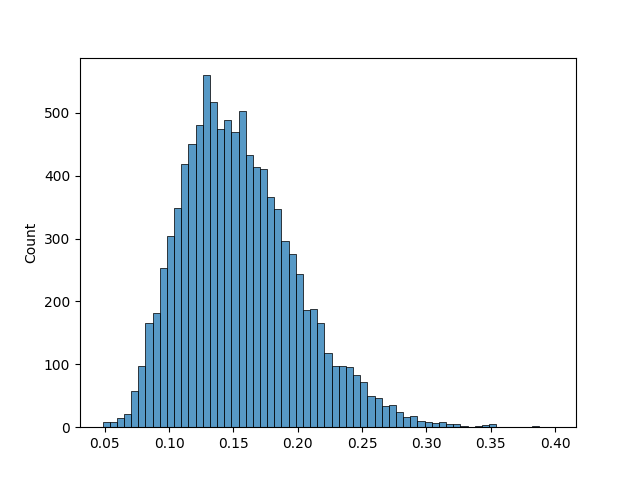

In [3]:
# example of Customer class
# it generates a random customer with preferences based on products popularity
c = Customer(products)
print(c.preferences)
print(c['coke'])

preferences = []
for _ in range(10_000):
    c = Customer(products)
    preferences.append(*c['beer'])
    
plt.figure()
sns.histplot(data=np.array(preferences))
plt.show()

In [24]:
local_time = SimulationTime() # basically a counter to keep things sync

In [22]:
# primary attribute of the location is it's traffic that may be random and given by confidence interval
l = Location('Sakh', traffic_CI=(15, 30))
l.visits_today  # generates within confidence interval provided from lognormal distribution

25

In [20]:
columns = {  # name of product, count
    'coke': 20,
    'beer': 10,
}

# currently it's a dict, no definition of columns, but total ammount

In [33]:
# example of VendingMachine class
vm = VendingMachine(name='vm', location=l, time=local_time, columns=[
    ('coke', 10),
    ('coke', 10),
    ('beer', 10),
    ])
vm.refill({'coke': 15, 'beer': 20})
vm.available_products
vm.inventory
vm.capacity

defaultdict(<function vmSim.VendingMachine.capacity.<locals>.<lambda>()>,
            {'coke': 20, 'beer': 10})

# Refill strategies

In [37]:
class FillUpExistingToMaxOnMinLevel(BaseStrategy):
    def __init__(self, name: str, min_levels: dict[str, int], how_many_should_hit_min: int=1):
        self.name = name
        self.min_levels = min_levels
        self.how_many_should_hit_min = how_many_should_hit_min
    
    def make_refil_decision(self, vending_machine: VendingMachine) -> Decision:
        """
        takes state of provided vending machine and makes decision to refill or not
        if refill, returns product-ammount dict
        if not, returns False
        """
        self.vm = vending_machine
        decision: Decision = {}
        for name, ammount in self.vm.inventory.items():
            if ammount < self.min_levels[name]:
                decision[name] = self.vm.capacity[name]
        if len(decision) < self.how_many_should_hit_min:
            decision = False
        return decision

In [38]:
class FillUpAllExistingToMaxOnMinLevel(BaseStrategy):
    def __init__(self, name: str, min_levels: dict[str, int], how_many_should_hit_min: int=1):
        self.name = name
        self.min_levels = min_levels
        self.how_many_should_hit_min = how_many_should_hit_min
    
    def make_refil_decision(self, vending_machine: VendingMachine) -> Decision:
        """
        takes state of provided vending machine and makes decision to refill or not
        if refill, returns product-ammount dict
        if not, returns False
        """
        self.vm = vending_machine
        decision: Decision = {}
        hit_min = 0
        for name, ammount in self.vm.inventory.items():
            decision[name] = self.vm.capacity[name]
            if ammount < self.min_levels[name]:
                hit_min += 1
        if hit_min < self.how_many_should_hit_min:
            decision = False
        return decision

# Simulation

## Set up

In [38]:
dict(pd.DataFrame(columns=[
     'name',      'CI',    'size', 'cost', 'margin'], data=[
    ('papa_beer', (30, 50), 330,    250,     70),
    ('mama_beer', (10, 20), 330,    300,    100),
    ('baby_beer', ( 1,  5), 250,    200,    150),
    ('water',     (15, 25), 500,    100,     50),
])[['name', 'CI']].to_dict('split')['data'])

{'papa_beer': (30, 50),
 'mama_beer': (10, 20),
 'baby_beer': (1, 5),
 'water': (15, 25)}

In [39]:
local_time = SimulationTime()

# -- Locations --

low_traffic_loc = Location('boring place', traffic_CI=(3, 10))
high_traffic_loc = Location('railroad', traffic_CI=(20, 40))

# -- Products --

PRODUCTS = pd.DataFrame(columns=[
     'name',      'CI',    'size', 'cost', 'margin'], data=[
    ('papa_beer', (30, 50), 330,    250,     70),
    ('mama_beer', (10, 20), 330,    300,    100),
    ('baby_beer', ( 1,  5), 250,    200,    150),
    ('water',     (15, 25), 500,    100,     50),
])


# -- VMs --
vm1 = VendingMachine(name='vm1', location=low_traffic_loc, time=local_time, columns=[
    ('papa_beer', 40),
    ('papa_beer', 40),
    ('water', 30),
    ('water', 30),
])

vm2 = VendingMachine(name='vm2', location=high_traffic_loc, time=local_time, columns=[
    ('papa_beer', 40),
    ('mama_beer', 40),
    ('baby_beer', 40),
    ('water', 30),
])


VMs = [vm1, vm2]

# -- Strategies -- 
s_topup_at_const = FillUpExistingToMaxOnMinLevel('top_at_10', min_levels={
    'papa_beer': 10,
    'mama_beer': 10,
    'baby_beer': 10,
    'water'    : 10,      
})
s_topup_at_var = FillUpExistingToMaxOnMinLevel('top_based_on_pop', min_levels={
    'papa_beer': 15,
    'mama_beer': 10,
    'baby_beer': 5,
    'water'    : 15,      
})

STGs = {
    vm1: s_topup_at_const,
    vm2: s_topup_at_const,
}

## Running cycle

In [47]:
sim = Simulation('test run', 
                 products=PRODUCTS, 
                 VMs=VMs,
                 STGs=STGs,
                 cycles=50,
                 local_time=local_time)

sim.run()

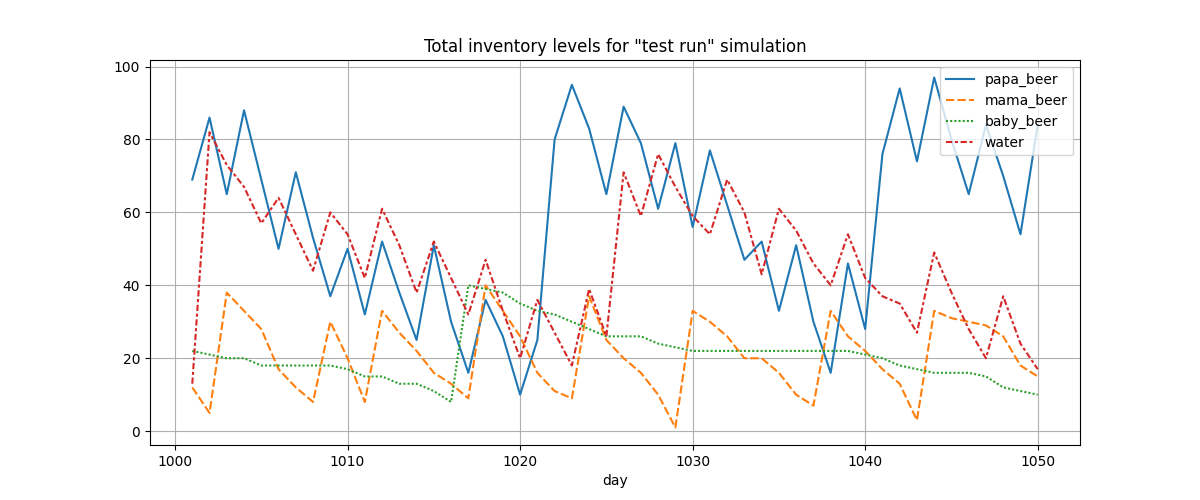

In [48]:
sim.plot_stat('total_inventory_levels')

Average inventory cost per day: 29,456.0 (sigma 6,661.7)


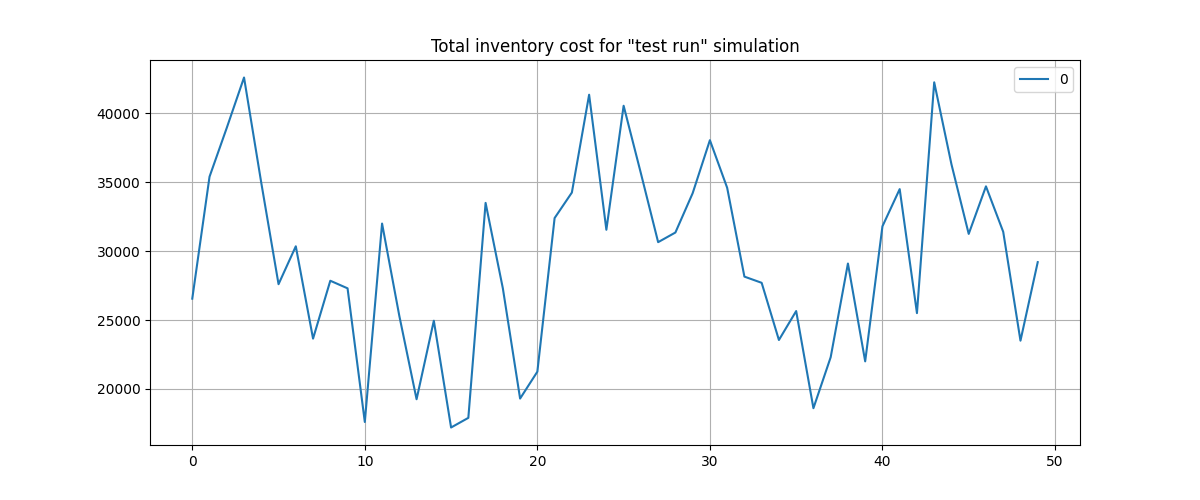

In [49]:
print(f'Average inventory cost per day: {np.mean(sim.total_inventory_cost):,.1f} (sigma {np.std(sim.total_inventory_cost):,.1f})')
sim.plot_stat('total_inventory_cost')

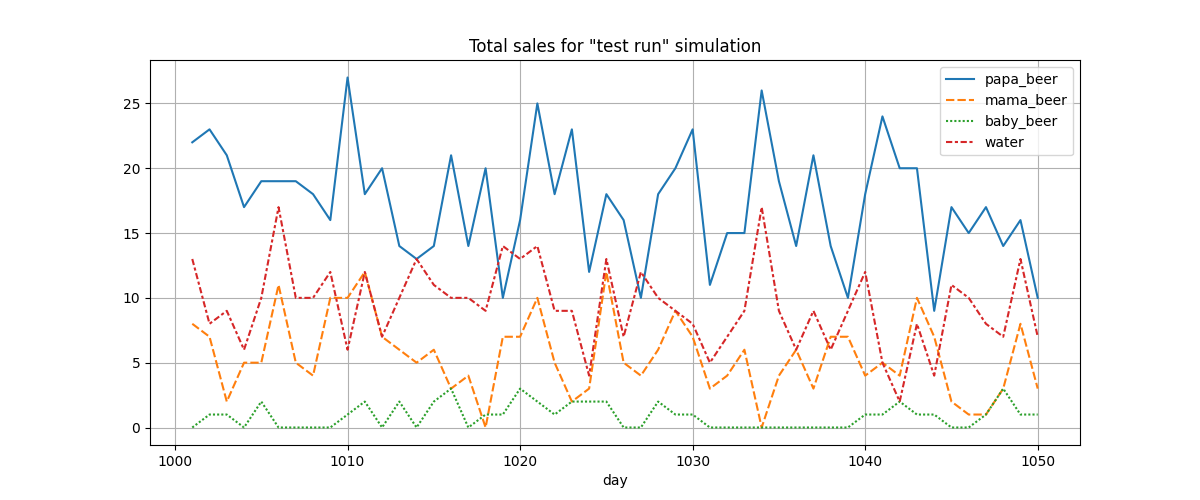

In [50]:
sim.plot_stat('total_sales')

Total sold outs for simulations: 31


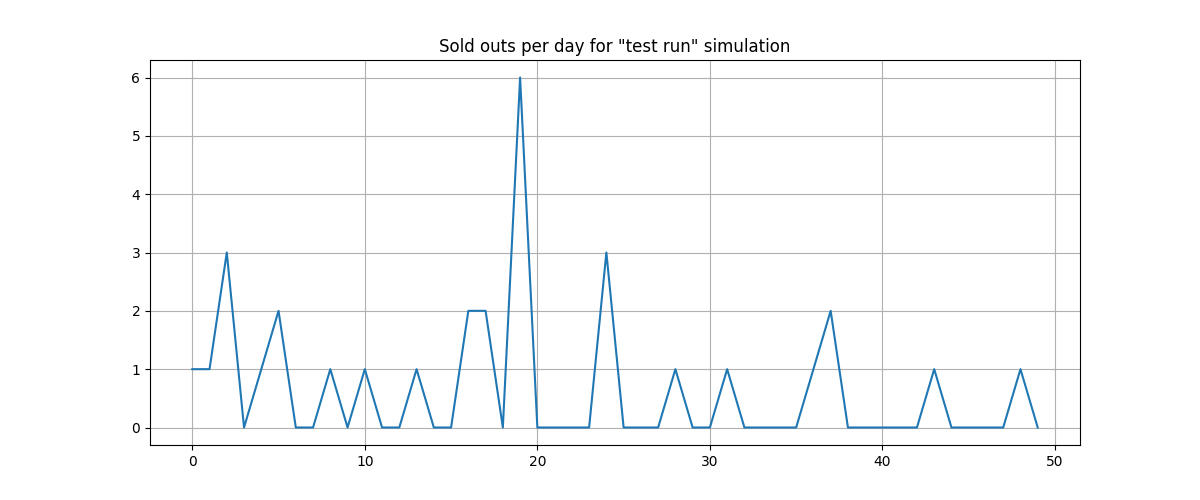

In [51]:
print(f'Total sold outs for simulations: {sum(sim.sold_outs_per_day)}')
sim.plot_stat('sold_outs_per_day')

Average profit per day: 2367.6 (sigma 540.4)


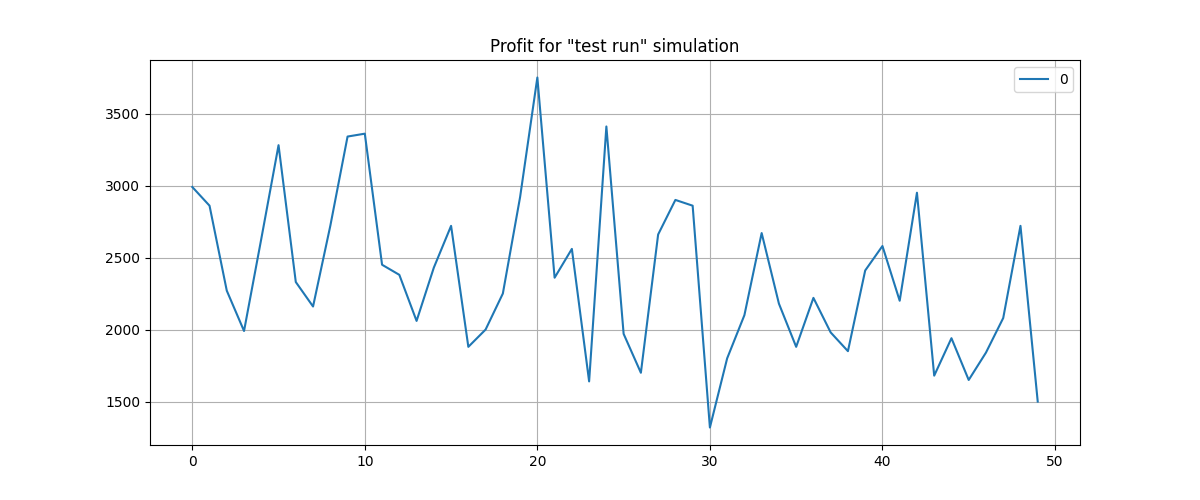

In [52]:
print(f'Average profit per day: {np.mean(sim.profit):.1f} (sigma {np.std(sim.profit):.1f})')
sim.plot_stat('profit')

Total top ups for simulations: 35


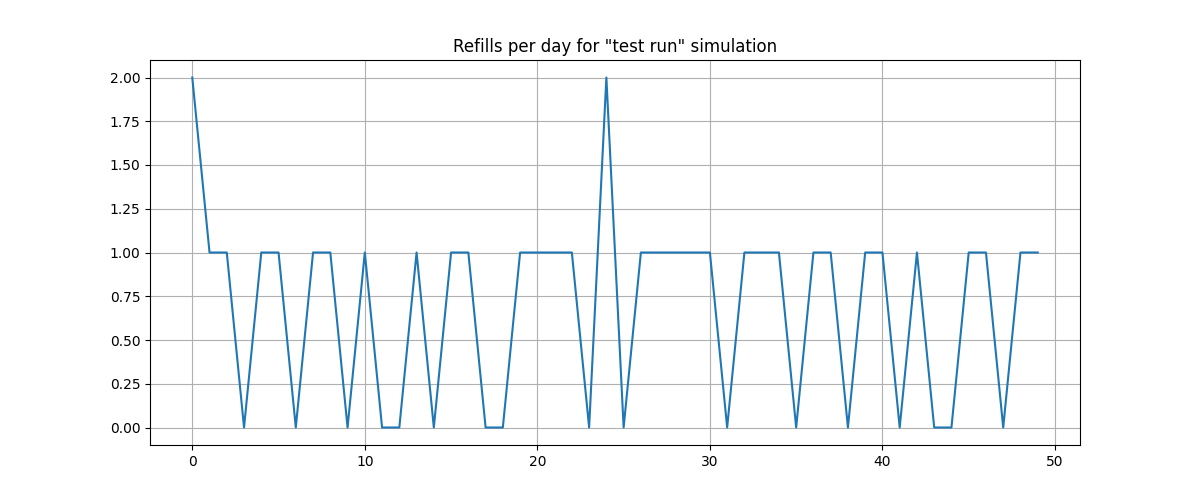

In [53]:
print(f'Total top ups for simulations: {sum(sim.refills_per_day)}')
sim.plot_stat('refills_per_day')

## Sort of economic model

In [18]:
interest_rate = 0.03
trip_cost = 500

In [19]:
expenses = sum(refills_per_day) * trip_cost + np.mean(total_inventory_cost)/365 * len(total_inventory_cost) * interest_rate
profits = sum(profit)[0]
revenue = profits - expenses
print(f"{revenue:,.1f} = {profits:,.1f} - {expenses:,.1f}")

NameError: name 'refills_per_day' is not defined

strategies                revenue        profit         expenses

two low top ups:          16,881,656.2 = 23,223,010.0 - 6,341,353.8

two refills to max:       19,249,847.6 = 23,802,130.0 - 4,552,282.4

one low, one high top up: 18,481,499.1 = 24,001,140.0 - 5,519,640.9